# Correlate datasets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import math

In [82]:
from IPython.display import display, Markdown

In [3]:
import brsflufight_nerc2  as bff2

## Prepare data

In [109]:
data_sets = bff2.load_data_files()

A loading function must be defined in `data_access.default_file_read_functions`.


Data is loaded into a `DataGroup` which is simply a dictionary which exposes the method `get_country`.

In [110]:
country = 'United Kingdom'

d_uk = data_sets.get_country(country)

Success: historical_GHG_Sectors_GCP
Success: historical_GHG_Sectors_PIK
Success: historical_GHG_Sectors_UNFCCC
Success: mobility_apple
Failed: United Kingdom not in mobility_citymapper
Success: mobility_google
Success: uk_energy_daily
Success: uk_energy_demand_reduction


### Prepare yearly energy data

For the energy we get the data for which we have full years of data and get the average power. We drop years with incomplete data (i.e. 2011  and 2020).

In [147]:
grouped_energy = d_uk['uk_energy_daily'].groupby(pd.Grouper(freq='1Y'))
years_with_enough_data = grouped_energy.count()["dayofyear"]>350
d_uk['uk_energy_yearly'] = grouped_energy.mean()[years_with_enough_data]
d_uk['uk_energy_yearly'].set_index(pd.to_datetime(d_uk['uk_energy_yearly'].index.year,format="%Y"), inplace=True)

In [111]:
grouped_energy = d_uk['uk_energy_demand_reduction'].groupby(pd.Grouper(freq='1Y'))
d_uk['uk_energy_demand_reduction_yearly'] = grouped_energy.mean()
d_uk['uk_energy_demand_reduction_yearly'].set_index(pd.to_datetime(d_uk['uk_energy_demand_reduction_yearly'].index.year,format="%Y"), inplace=True)

In [112]:
d_uk['uk_energy_demand_reduction_yearly'].head()

,energy_demand_with_corona,energy_demand_without_corona,energy_demand_reduction
timestamp,,,
2020-01-01,28468.039187,32807.742092,4339.702905


### Prepare combined column

In [152]:
d_uk['historical_GHG_Sectors_GCP']['Gas and Coal (CO2)'] = \
    d_uk['historical_GHG_Sectors_GCP']['Gas (CO2)'] + d_uk['historical_GHG_Sectors_GCP']['Coal (CO2)']

## Correlating datasets

### Choice of datasets

First we define the datasets and the columns we want to correlate. Implicitely we are emitting the hypothesis:

*Column C in dataset X is correlated to column D in dataset Y.*

for all columns and datasets in the dictionary `to_correlate`.

In [155]:
to_correlate = {
    'uk_energy_yearly': ['oil', 'ccgt', 'coal', 'demand'],  # Carbon intensive energy sources
    'historical_GHG_Sectors_GCP': [  # Select only CO2 data not other gases
        s for s in d_uk['historical_GHG_Sectors_GCP'].columns if f"(CO2)" in s
    ],
    'historical_GHG_Sectors_PIK': [  # Select Energy data not other sectors
        'Energy (KYOTOGHG)', 'Energy (CO2)', 'Energy (N2O)', 'Energy (CH4)'
    ],
}

For this work we are correlating three datasets:

+ `'uk_energy_yearly'` The average yearly power consomption of the UK by type of power station.
+ `'historical_GHG_Sectors_GCP'` the global carbon project's breakdown of yearly carbon emissions by fossil fuel.
+ `'historical_GHG_Sectors_PIK'` The Potsdam Institute for climate change impact research (PIK) breakdown of yearly carbon emissions by sector of the economy.

The first 3 lines are displayed in the subsections below:

In [156]:
for d in to_correlate:
    display(Markdown(f"#### dataset `'{d}'`'"))
    display(d_uk[d].tail(3))

#### dataset `'uk_energy_yearly'`'

,demand,coal,nuclear,ccgt,wind,pumped,hydro,biomass,oil,solar,ocgt,other,dayofyear
timestamp,,,,,,,,,,,,,
2017-01-01,31858.397066,2357.162886,7484.045780,13678.825019,3689.535314,316.498433,457.617018,1627.341894,0.000000,1189.161055,1.890384,14.902725,183.0
2018-01-01,31458.583256,1764.089781,6923.616315,13205.261560,4498.223694,271.923046,366.609060,1840.524415,0.004410,1248.855466,2.098168,81.660209,183.0
2019-01-01,30606.290673,679.510313,6022.150777,13080.728889,5302.395747,195.267497,408.815841,1965.136313,0.011887,1230.144531,7.983079,88.507691,183.0


#### dataset `'historical_GHG_Sectors_GCP'`'

,Country,date,Data source,Unit,Bunkers (CO2),Cement (CO2),Coal (CO2),Gas (CO2),Gas flaring (CO2),Oil (CO2),Total fossil fuels and cement (CO2),Gas and Coal (CO2)
date,,,,,,,,,,,,
2016-01-01,United Kingdom,2016-01-01,GCP,MtCO₂e,NaN,4.55,47.10,165.77,4.52,175.19,399.84,212.87
2017-01-01,United Kingdom,2017-01-01,GCP,MtCO₂e,NaN,4.41,38.44,161.79,4.59,175.37,387.39,200.23
2018-01-01,United Kingdom,2018-01-01,GCP,MtCO₂e,NaN,4.41,32.07,161.92,4.59,173.26,379.04,193.99


#### dataset `'historical_GHG_Sectors_PIK'`'

,Country,date,Data source,Unit,Agriculture (CH4),Energy (CH4),Industrial Processes and Product Use (CH4),Other (CH4),Total excluding LULUCF (CH4),Waste (CH4),...,Total excluding LULUCF (KYOTOGHG),Waste (KYOTOGHG),Agriculture (N2O),Energy (N2O),Industrial Processes and Product Use (N2O),Other (N2O),Total excluding LULUCF (N2O),Waste (N2O),Industrial Processes and Product Use (F-Gas),Total excluding LULUCF (F-Gas)
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,United Kingdom,2015-01-01,PIK,MtCO₂e,25.75,7.90,0.08,NaN,53.0,19.33,...,520.0,21.0,14.10,2.62,0.85,1.18,20.17,1.42,16.0,16.0
2016-01-01,United Kingdom,2016-01-01,PIK,MtCO₂e,25.75,6.98,0.09,NaN,51.5,18.65,...,495.0,20.4,14.10,2.49,0.86,1.12,20.03,1.46,15.2,15.2
2017-01-01,United Kingdom,2017-01-01,PIK,MtCO₂e,26.00,7.00,0.08,NaN,52.0,18.90,...,482.0,20.7,14.36,2.51,0.89,1.07,20.35,1.49,14.2,14.2


### Calculating correlations


Once chosen we pass it to function [`correlate`](brsflufight_nerc2/model_predict.py) 
which calculates and returns correlations between columns of the datasets in `selector` and the dataset defined by `main_compare`. Linear fits for each correlation are also computed.

In [157]:
correlation_dict = bff2.correlate(
    selector=to_correlate,  # datasets defined above
    data_sets=d_uk,  # UK data
    main_compare='uk_energy_yearly',  # reference dataset, the other are correlated to it
)

Linear regression failed for: 'Bunkers (CO2)' fit to  'oil':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Linear regression failed for: 'Bunkers (CO2)' fit to  'ccgt':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Linear regression failed for: 'Bunkers (CO2)' fit to  'coal':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Linear regression failed for: 'Bunkers (CO2)' fit to  'demand':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').


`bff2.correlate` returns a dictionary of dictionaries corresponding to the datasets that were correlated to `main_compare` (in this case `'uk_energy_yearly'`).
For each dataset 3 items are returned:

  + a `'correlation'`: the pearson correlation coefficient between datasets;
  + the merged `'data'` used for the correlation;
  + a linear `'fit'` between the datasets done through `scikit-learn` `LinearRegression`;
 
We can visualise the correlations to identify relationships of interest, we are looking for numbers close to 1.

In [158]:
for dset in correlation_dict:
    print("=====================================================================")
    print(f"Pearson correlation coefficients in dataset '{dset}'")
    min_d = correlation_dict[dset]['data'].index.min()
    max_d = correlation_dict[dset]['data'].index.max()
    print(f"\t on data from {min_d.year} to {max_d.year} (inclusive)")
    print("_________________________________________________________")
    display(
        correlation_dict[dset]['correlation']
        .style.background_gradient().set_precision(3)
    )
    print("=====================================================================")
    print("")

Pearson correlation coefficients in dataset 'historical_GHG_Sectors_GCP'
	 on data from 2012 to 2018 (inclusive)
_________________________________________________________


,Bunkers (CO2),Cement (CO2),Coal (CO2),Gas (CO2),Gas flaring (CO2),Oil (CO2),Total fossil fuels and cement (CO2),Gas and Coal (CO2)
oil,nan,-0.845,0.883,-0.613,-0.700,-0.883,0.883,0.883
ccgt,nan,0.739,-0.786,0.643,0.487,0.857,-0.786,-0.786
coal,nan,-0.703,1.000,-0.571,-0.775,-0.786,1.000,1.000
demand,nan,-0.703,1.000,-0.571,-0.775,-0.786,1.000,1.000



Pearson correlation coefficients in dataset 'historical_GHG_Sectors_PIK'
	 on data from 2012 to 2017 (inclusive)
_________________________________________________________


,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4)
oil,0.986,0.986,0.812,0.986
ccgt,-0.829,-0.829,-0.829,-0.886
coal,1.000,1.000,0.771,0.943
demand,1.000,1.000,0.771,0.943


Before predicting the emissions based on GHG let us check what the data from which we predict is like

### Refining dataset and column selections

Not all these relationships will enable prediction of GHG emissions. In the subsections below
correlations between GHG emissions and: closed cycle gas turbine power stations (`'ccgt'`), coal power stations (`'coal'`) and, fuel power stations (`'fuel'`); are discussed.

#### Rejecting `'ccgt'`

'Combine cycle gas turbine' used is inversely correlated with GHG emissions. This is because
there are two drivers of the long term trend in GHG emissions reduction due to the energy sector:

+ Transition to cleaner fossil fuel sources of power ('ccgt' rather than 'coal');
+ Reduction in 'demand';
+ And increase in renewables.

A possibly exploitable correlation can be seen with the global carbon project dataset, specifically gas use. For the purpose of this prototype this was not done, and the power produced by `'ccgt'` are not used. 

#### Rejecting `'oil'`

Plotting the '`oil`' data, shows that despite high correlation it is 4 orders of magnitude lower than the other power generation methods. This suggests that the correlation is not significant.

,oil,ccgt,coal,demand
count,8.000000,8.000000,8.000000,8.000000
mean,0.508933,11579.530732,7192.968170,33331.404544
std,0.796658,2229.139008,5982.333526,2221.087664
min,0.000000,9148.029085,679.510313,30606.290673
25%,0.003308,9603.858167,2208.894609,31758.443613
50%,0.154770,11489.689029,5852.376027,32712.718536
75%,0.650764,13323.652425,11866.890665,34907.808907
max,2.309853,14506.012432,15641.439384,36581.013455


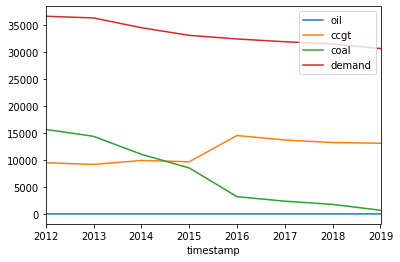

In [39]:
dsource = 'uk_energy_yearly'
d_uk[dsource].plot(y=to_correlate[dsource])
d_uk[dsource][to_correlate[dsource]].describe()

#### Rejecting `'coal'`

Because 'coal' plants are stopped preferentially data is truncated from mid-April in 2020 as they have not been in use. This implies that some of the lockdown impact will be missed at least when using the PIK GHG emission dataset. 

Indeed the global carbon project (GCP) includes data broken down by fuel. While not all those emissions will be the energy sector strong correlations can still be observed. These metrics can also be predicted using the same framework.

Because of this truncation `'coal'` is not used for predictions.


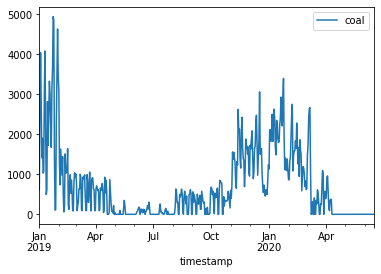

In [40]:
d_uk['uk_energy_daily'].loc[d_uk['uk_energy_daily'].index >= "2019", to_correlate[dsource]].plot(y='coal')


## Predicting GHG emissions from the Energy sector from energy demand

From the correlations emissions are predicted based on the 
data from the Potsdam institute for climate impact research (PIK) ([Gütschow et al., 2016,](http://doi.org/10.5194/essd-8-571-2016)) (called '`historical_GHG_Sectors_PIK`' in our framework, [data download](https://dataservices.gfz-potsdam.de/pik/showshort.php?id=escidoc:4736895)) using specifically:

+ 'demand' : The average yearly power demand;

In order to predict emissions, this quantity needs to be 
These values are predicted in [`predict.ipynb`]()

In [41]:
prediction_data_set = correlation_dict['historical_GHG_Sectors_PIK']

### Example prediction on the avilable data

In [42]:
df = d_uk['uk_energy_yearly']
pred_x = df.loc[
    (df.index >= "2010") & (df.index < "2020"), ["demand"]
]
pred_x

,demand
timestamp,
2012-01-01,36581.013455
2013-01-01,36266.654436
2014-01-01,34454.860398
2015-01-01,33048.731071
2016-01-01,32376.706000
2017-01-01,31858.397066
2018-01-01,31458.583256
2019-01-01,30606.290673


Using function `bff2.apply_prediction` applies the linear prediction to each correlated column

In [43]:
pred = bff2.apply_prediction(prediction_data_set['fit'], pred_x)
pred

predictor_value  Energy (KYOTOGHG)  Energy (CO2)  \
predictor date                                                           
demand    2012-01-01     36581.013455         482.359227    470.181559   
          2013-01-01     36266.654436         475.920961    463.934571   
          2014-01-01     34454.860398         438.814309    427.930338   
          2015-01-01     33048.731071         410.015919    399.987533   
          2016-01-01     32376.706000         396.252434    386.632954   
          2017-01-01     31858.397066         385.637150    376.333044   
          2018-01-01     31458.583256         377.448718    368.387887   
          2019-01-01     30606.290673         359.993244    351.451006   

                      Energy (N2O)  Energy (CH4)  
predictor date                                    
demand    2012-01-01      2.639577      9.378003  
          2013-01-01      2.631613      9.218119  
          2014-01-01      2.585714      8.296638  
          2015-01-01      2.550092      7.581479  
          2016-01-01      2.533067      7.239686  
          2017-01-01      2.519936      6.976074  
          2018-01-01      2.509808      6.772728  
          2019-01-01      2.488216      6.339251

It is useful to check here what the correlations between predictors (rows) and predicted values are (columns) 

In [46]:
display(
    prediction_data_set['correlation'].loc[pred.index.get_level_values(0).unique()]
    .style.background_gradient().set_precision(3)
)

,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4)
predictor,,,,
demand,1.000,1.000,0.771,0.943


Now let us check the prediction on the 'training set'

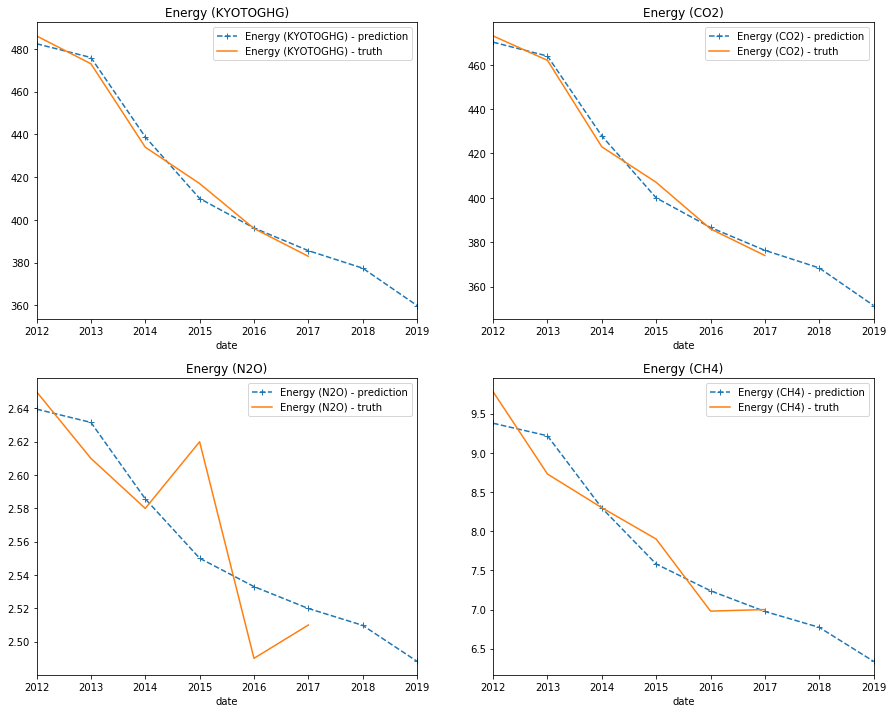

In [48]:
analysis_cols = [c for c in pred.columns if c in prediction_data_set['data']]

mask_pred = (pred.loc["demand"].index <= truth.index.max())
truth = prediction_data_set['data'].loc[pred.loc["demand"].index[mask_pred], analysis_cols]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(15, 12)
axs = axs.flatten()
for i, analysis_col in enumerate(analysis_cols):
    current_cols = [analysis_col]
    axs[i].set_title(f"{analysis_col}")
    pred.loc["demand", current_cols].plot(
        y=current_cols,
        ax=axs[i], label=[f"{c} - prediction" for c in current_cols],
        linestyle='--', marker='+'
    )
    truth[current_cols].plot(
        y=current_cols,
        ax=axs[i], label=[f"{c} - truth" for c in current_cols],
    )

As expected for the data sets with the highest correlation the fit is very good.

In [70]:
err = (((pred.loc["demand", analysis_cols] - truth)/truth))
print("Percentage errors between prediction and truth")
display(err.style.format('{:,.2%}'.format))

Percentage errors between prediction and truth


,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4)
date,,,,
2012-01-01 00:00:00,-0.75%,-0.60%,-0.39%,-4.11%
2013-01-01 00:00:00,0.62%,0.42%,0.83%,5.59%
2014-01-01 00:00:00,1.11%,1.17%,0.22%,-0.04%
2015-01-01 00:00:00,-1.67%,-1.72%,-2.67%,-4.03%
2016-01-01 00:00:00,0.06%,0.16%,1.73%,3.72%
2017-01-01 00:00:00,0.69%,0.62%,0.40%,-0.34%
2018-01-01 00:00:00,nan%,nan%,nan%,nan%
2019-01-01 00:00:00,nan%,nan%,nan%,nan%


### Predicting 2020 with and without lockdowns

Because 2020 is not finished we must model the expected average energy consumption with and without lockdowns.



In [115]:
pred_corona = d_uk['uk_energy_demand_reduction_yearly']
pred_corona

,energy_demand_with_corona,energy_demand_without_corona,energy_demand_reduction
timestamp,,,
2020-01-01,28468.039187,32807.742092,4339.702905


In [121]:
pred_corona.drop(["energy_demand_reduction"], axis='columns', inplace=True)

In [122]:
pred = bff2.apply_prediction(
    prediction_data_set['fit'],
    pred_corona,
    {c: 'demand' for c in pred_corona}
)

In [123]:
difference = pred.loc["energy_demand_with_corona"]-pred.loc["energy_demand_without_corona"]
ratio = (difference)/pred.loc["energy_demand_with_corona"]

difference["quantity"] = "absolute difference"
ratio["quantity"] = "relative difference"

change_corona = pd.concat([difference,ratio])

In [126]:
print("Predicted GHG emissions based on energy demand:")
print("___________________________________________________")
display(pred)
print("")
print("")
print("Predicted change in GHG emissions based on energy demand:")
print("_____________________________________________________________")
display(change_corona)

Predicted GHG emissions based on energy demand:
___________________________________________________


,,predictor_value,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4)
predictor,date,,,,,
energy_demand_with_corona,2020-01-01,28468.039187,316.200543,308.959363,2.434046,5.251733
energy_demand_without_corona,2020-01-01,32807.742092,405.080317,395.198566,2.543987,7.458912




Predicted change in GHG emissions based on energy demand:
_____________________________________________________________


,predictor_value,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4),quantity
date,,,,,,
2020-01-01,-4339.702905,-88.879774,-86.239202,-0.109940,-2.207179,absolute difference
2020-01-01,-0.152441,-0.281087,-0.279128,-0.045168,-0.420276,relative difference


## Outcomes

From this framework the predicted reduction in GHG emissions for the energy sector is:

+ from column `'Energy (KYOTOGHG)'` above: $89\ [MtCO_2e]$ (Megatons of $CO_2$ equivalent);
+ it corresponds to a 28% reduction of emissions for the sector due to a fall in demand of 15%.

This observation suggests that demand reduction will provide an effective route to de-carbonisation: for each
point of demand lost, almost two points of emissions are lost for the sector.   

In [141]:
d_PIK = d_uk['historical_GHG_Sectors_PIK'].tail(1)
d_PIK = d_PIK[[c for c in d_PIK if '(KYOTOGHG)' in c]]
d_energy_prop = (d_PIK['Energy (KYOTOGHG)']/d_PIK['Total excluding LULUCF (KYOTOGHG)'])

print(f"Energy sector proportion (Excluding LULUCF) {d_energy_prop['2017']}")

Energy sector proportion (Excluding LULUCF) date
2017-01-01    0.794606
dtype: float64
